# Tutorial Notebook : EXACT SINOGRAM

In [1]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d

from skimage.transform import iradon, radon

from scipy.ndimage import sobel
from scipy.ndimage import binary_dilation

%matplotlib inline

In [2]:
##############################################################################
# import of the phantom library which contain the phantom class
import exact_sinogram as esin

In [3]:
##############################################################################
# gradient with Sobel transform
def gradient(A):
    return np.sqrt(sobel(A, axis=0)**2 + sobel(A, axis=-1)**2)

In [4]:
##############################################################################
# iterative binary dilation  
def ndilate(A,n):
    for i in range(n):
        A = binary_dilation(A)
    return A

In [5]:
##############################################################################
# Absolute and relative error functions on masked image

def error_abs(X,Targ, p = np.inf, k =2):
    
    Mask = ndilate(gradient(Targ)>.5, k)
    Error = X-Targ
    Error[Mask==1] = 0
    Error[Targ==0] = 0
    return np.linalg.norm(Error,p)


def error_rel(X,Targ,p = np.inf, k=2):
    Mask = ndilate(gradient(Targ)>.5, k)
    Error = X-Targ
    Error[Mask==1] = 0
    Error[Targ==0] = 0
    Targ2 = np.copy(Targ)
    Targ2[Mask==1] = 0
    return np.linalg.norm(Error,p)/np.linalg.norm(Targ2, p)


# Creation of the Phantom

In [28]:
circle = True
phantom_type ='rectangles' # 'modified_shepp_logan'
#  phantom_type : 'ellipses' (or 'shepp_logan') , 'modified_shepp_logan', 'squares', 'rectangles'
n_points = 300;   # number of pixels

##############################################################################
# Creation of an instance of the Phantom Class,, with the fields: 
# .phantom_type: the type of the phantom "ellipses", "squares" or "rectangles"
# .matrix:       the matrix of the information of the objects that define it 
# .circle:       an option for the sinogram calculation
        
Phm = esin.Phantom(phantom_type = phantom_type, circle = circle)


##############################################################################
# Creation of the matrix-image of the phantom, wth input the number of pixel:
P = Phm.get_phantom(N = n_points)


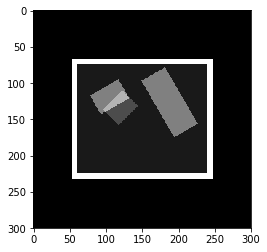

<Figure size 432x288 with 0 Axes>

In [29]:
##############################################################################
# Plot of the phantom image
plt.imshow(P, cmap = cm.gray); plt.show();
plt.savefig('images/phantom_'+phantom_type+'.png',format='png')

# Calculation of the Sinograms

In [30]:
##############################################################################
# Creation of the vector theta of the angles on which the Radon is calculated
theta_vec_deg = np.linspace(0, 359, 360)
theta_vec_rad = np.deg2rad(theta_vec_deg)


##############################################################################
# Calculation of the Sinogram with the analytical Radon
analytical_sinogram = Phm.get_sinogram(N = n_points, theta_vec = theta_vec_rad)


##############################################################################
# Calculation of the Sinogram with the numerical Radon 
sinogram = radon(P, theta=theta_vec_deg, circle=circle)


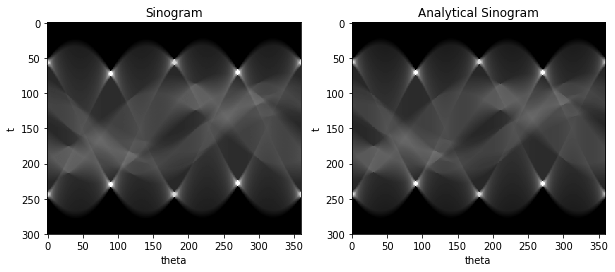

In [31]:
##############################################################################
# Plot 
plt.figure(figsize=(10,20)) 
plt.subplot(1,2,1)

plt.imshow(sinogram, cmap = cm.gray)
plt.xlabel('theta')
plt.ylabel('t')
plt.title('Sinogram')

plt.subplot(1,2,2)
plt.imshow(analytical_sinogram, cmap = cm.gray)
plt.xlabel('theta')
plt.ylabel('t')
plt.title('Analytical Sinogram')
plt.savefig('images/analytical_sinograms_'+phantom_type+'.png',format='png');
plt.show()


# Backprojection with the iradon function of the library Skimage

In [32]:
##############################################################################
# Backprojection with iradon
P_an = (iradon((analytical_sinogram), theta = theta_vec_deg, circle=circle ))
P_inv = (iradon((sinogram), theta= theta_vec_deg , circle=circle)) 


# Analysis of the results

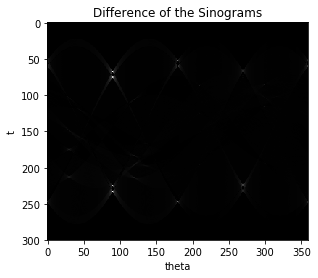

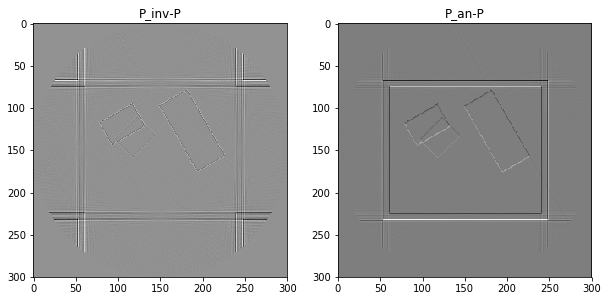

In [33]:
##############################################################################
# Difference between the sinograms
err_sinograms = abs(analytical_sinogram - sinogram)
plt.figure();
plt.imshow(err_sinograms, cmap = cm.gray)
plt.xlabel('theta')
plt.ylabel('t')
plt.title('Difference of the Sinograms')
plt.show()

##############################################################################
# Difference between the original and recontructed phantoms
plt.figure(figsize=(10,20)) 
plt.subplot(1,2,1)
plt.imshow(P_inv-P, cmap = cm.gray)
plt.title('P_inv-P')

plt.subplot(1,2,2)
plt.imshow(P_an-P, cmap = cm.gray)
plt.title('P_an-P')
plt.show()


In [34]:
##############################################################################
# Errors
k = 0;

print('Absolute error P_an: ',error_abs(P_an, P,p=2,k=k)) 
print('Relative error P_an: ',error_rel(P_an, P,p=2 ,k=k))
print('Absolute error P_inv: ',error_abs(P_inv, P, p=2,k=k))  
print('Relative error P_inv: ',error_rel(P_inv, P, p=2,k=k))


Absolute error P_an:  8.893852756847165
Relative error P_an:  0.1355899398966559
Absolute error P_inv:  3.077451347333029
Relative error P_inv:  0.04691683735134032


In [35]:
##############################################################################
# Errors taking into account Gibbs phenomenon
k = 2;

print('Absolute error P_an: %.3f'%error_abs(P_an, P,p=2,k=k)) 
print('Relative error P_an: %.5f'%error_rel(P_an, P,p=2 ,k=k))
print('Absolute error P_inv: %.3f'%error_abs(P_inv, P, p=2,k=k))  
print('Relative error P_inv: %.5f'%error_rel(P_inv, P, p=2,k=k))

Absolute error P_an: 0.780
Relative error P_an: 0.01838
Absolute error P_inv: 1.098
Relative error P_inv: 0.02588


In [36]:
##############################################################################
# Definition of the mask
Mask = ndilate(gradient(P)>.5,k)

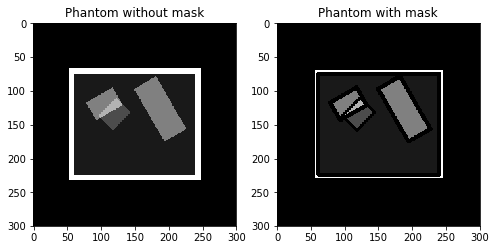

In [37]:
##############################################################################
# Phantom with and without mask
PP=P.copy()
PP[Mask]=0

plt.figure(figsize=(8,15))
plt.subplot(1,2,1)
plt.imshow(P, cmap=cm.gray)
plt.title('Phantom without mask')

plt.subplot(1,2,2)
plt.imshow(PP, cmap=cm.gray)
plt.title('Phantom with mask');